In [1]:
TRAIN = 'speech_cmd'

In [2]:
speech_path = "../input/train/audio/"
speech_files = ['go', 'stop', 'yes', 'no']
speech_setup = 'speech_setup/'
speech_setup_data = speech_path+'data/'
rakshak_path = 'rakshak/'

In [3]:
!pip install kapre tensorflow-gpu

     |████████████████████████████████| 377.0MB 56kB/s 


In [4]:
# put dataset in folder named rakshak

Cloning into 'rakshak'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 7923 (delta 2), reused 12 (delta 1), pack-reused 7910
Receiving objects: 100% (7923/7923), 548.20 MiB | 21.45 MiB/s, done.
Resolving deltas: 100% (619/619), done.
Checking out files: 100% (7848/7848), done.


In [5]:
import os
import random
import numpy as np
from scipy.io import wavfile
import librosa
from tqdm import tqdm
import gc

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase

import plotly as py
py.tools.set_credentials_file(username='Ujjwal999',api_key='<your-key>')

import plotly.plotly as py
import plotly.graph_objs as go

# import cufflinks as cf
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
import kapre
from keras.models import Sequential
from keras.layers import Dense,AveragePooling2D
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise
import keras
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,SeparableConv2D,BatchNormalization,LSTM,Reshape,TimeDistributed

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

random.seed(4)

Using TensorFlow backend.


In [6]:
if not os.path.isdir('rakshak/models'):
    os.mkdir('rakshak/models')
else:
    print("Already There")

In [7]:
def roll(data):
    data_roll = np.roll(data, 5000)
    return data_roll

def stretch(data, rate=2):
    input_length = 16000*3
    data = librosa.effects.time_stretch(np.array(data, dtype=np.float32), rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data.tolist()

def wnoise(data):
    wn = np.random.randn(len(data))
    data_wn = data + 0.005*wn
    return data_wn

In [8]:
def make_3_second(path, files):
    sr, data = wavfile.read(path+files)
    data = data.tolist()
    for i in range(2):
        data_1 = [0]*16000
        r = random.random()
        if r >= 0.5:
            data.extend(data_1)
        else:
            data_1.extend(data)
            data = data_1        
    if len(data) != 48000:
        data.extend([0]*(48000-len(data)))
    data = data[:48000]
    return data

In [9]:
def speech_command(new_split=True, speech_setup=speech_setup):
    speech_split = {'train.txt':[], 'test.txt':[], 'valid.txt':[]}
    for file in speech_split.keys():
        if os.path.exists(speech_setup+file):
#             os.remove(speech_setup+file)
#             split_speech_cmd = True
            new_split = False
            with open(file) as f:
                for line in f:
                    speech_split[key].append(line.strip())
    speech_cmd = {'train':[[],[]], 'valid':[[],[]], 'test':[[],[]]}
    to_test = True
    for folder in speech_files:
        files = os.listdir(speech_path+folder)
        for file in tqdm(files):
            file_path = folder+'/'+file
            if new_split == False and os.path.isdir(speech_setup_data):
                sr, data = wavfile.read(speech_path, file_path)
#             if save_processed_speech_cmd_files and new_split:
#                 wavfile.write(speech_setup_data+file_path, 16000, np.array(data, dtype=np.int16))
            if new_split:
                r = random.random()
                if r <= 0.7:
                    if TRAIN == 'speech_cmd':
                        data = make_3_second(speech_path, file_path)
                        speech_split['train.txt'].append(file_path)
                        speech_cmd['train'][0].append(data[:48000])
                        speech_cmd['train'][1].append(folder)
                    else:
                        continue
                else:
                    data = make_3_second(speech_path, file_path)
                    if to_test:
                        to_test = False
                        speech_split['test.txt'].append(file_path)
                        speech_cmd['test'][0].append(data[:48000])
                        speech_cmd['test'][1].append(folder)
                    else:
                        to_test = True
                        speech_split['valid.txt'].append(file_path)
                        speech_cmd['valid'][0].append(data[:48000])
                        speech_cmd['valid'][1].append(folder)
            else:
                if (file_path in speech_split['train.txt']):
                    if TRAIN == 'speech_cmd':
                        speech_cmd['train'][0].append(data[:48000])
                        speech_cmd['train'][1].append(folder)
                elif file_path in speech_split['valid.txt']:
                    speech_cmd['valid'][0].append(data)
                    speech_cmd['valid'][1].append(folder)
                else:
                    speech_cmd['test'][0].append(data)
                    speech_cmd['test'][1].append(folder)
    return speech_split, speech_cmd

In [10]:
speech_split, speech_cmd = speech_command()
gc.collect()

100%|██████████| 2375/2375 [00:08<00:00, 266.22it/s]


22

In [11]:
for key in speech_cmd.keys():
    speech_cmd[key][0] = np.array(speech_cmd[key][0])
    speech_cmd[key][1] = np.array(speech_cmd[key][1])

In [12]:
for key in speech_cmd.keys():
    print(key, ":", speech_cmd[key][0].shape)
gc.collect()

train : (6604, 48000)
valid : (1450, 48000)
test : (1450, 48000)


0

In [13]:
speech_cmd_train_data = speech_cmd['train'][0]
speech_cmd_train_labels = speech_cmd['train'][1]
speech_cmd_test_data = np.vstack((speech_cmd['test'][0], speech_cmd['valid'][0]))
speech_cmd_test_labels = []
for key in speech_cmd.keys():
    if key == 'train':
        continue
    speech_cmd_test_labels.extend(speech_cmd[key][1])
speech_cmd_test_labels = np.array(speech_cmd_test_labels)
print("speech_cmd train data shape: ", speech_cmd_train_data.shape)
print("speech_cmd train labels shape: ", speech_cmd_train_labels.shape)
print("speech_cmd test data shape: ", speech_cmd_test_data.shape)
print("speech_cmd test labels shape: ", speech_cmd_test_labels.shape)
del speech_cmd

speech_cmd train data shape:  (6604, 48000)
speech_cmd train labels shape:  (6604,)
speech_cmd test data shape:  (2900, 48000)
speech_cmd test labels shape:  (2900,)


In [14]:
sr = 16000
input_shape = (1,sr*3)
def edgespeechneta():
    tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/esna")
    model = Sequential()
    # A mel-spectrogram layer
    model.add(Melspectrogram(n_dft=512, n_hop=512, input_shape=input_shape,
                             padding='same', sr=sr, n_mels=128,
                             fmin=0.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True,trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft'))
    # Maybe some additive white noise.
    model.add(AdditiveNoise(power=0.1))
    # If you wanna normalise it per-frequency
    model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'
    # After this, it's just a usual keras workflow. For example..
    # Add some layers, e.g., model.add(some convolution layers..)

    # Compile the model
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(15, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(25, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(22, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(22, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(25, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(39, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(45, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    return model, "esna"

def edgespeechnetb():
    tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/edgespeechnet-b-100e")
    model = Sequential()
    # A mel-spectrogram layer
    model.add(Melspectrogram(n_dft=512, n_hop=512, input_shape=input_shape,
                             padding='same', sr=sr, n_mels=128,
                             fmin=0.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True,trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft'))
    # Maybe some additive white noise.
    model.add(AdditiveNoise(power=0.1))
    # If you wanna normalise it per-frequency
    model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'
    # After this, it's just a usual keras workflow. For example..
    # Add some layers, e.g., model.add(some convolution layers..)

    # Compile the model
    model.add(Conv2D(45, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(45, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(33, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(45, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(35, kernel_size=(3, 3), activation='relu',dim_ordering="th"))
    model.add(Conv2D(45, kernel_size=(3, 3), activation='relu',dim_ordering="th"))

    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model, "esnb"

def cnn():
    tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/cnn-100e")
    model = Sequential()
    # A mel-spectrogram layer
    model.add(Melspectrogram(n_dft=512, n_hop=512, input_shape=input_shape,
                             padding='same', sr=sr, n_mels=128,
                             fmin=0.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True,trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft'))
    # Maybe some additive white noise.
    model.add(AdditiveNoise(power=0.1))
    # If you wanna normalise it per-frequency
    model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'
    # After this, it's just a usual keras workflow. For example..
    # Add some layers, e.g., model.add(some convolution layers..)
    # Compile the model

    model.add(Conv2D(64, kernel_size=(20, 8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(10, 4), activation='relu',dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    return model, "cnn"

def AttRNNSpeechModel(nlabels, sr = sr, input_shape = input_shape):
    inputs = Input(shape=(1,sr*3))
    x = Melspectrogram(n_dft=512, n_hop=512, input_shape=input_shape,
                             padding='same', sr=sr, n_mels=128,
                             fmin=0.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True,trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft') (inputs)
    x = AdditiveNoise(power=0.1)(x)
    x = Normalization2D(int_axis=0)(x)
    x = Permute((2,1,3)) (x)
    x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
    x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences = True)) (x) 
    x = Bidirectional(CuDNNLSTM(64, return_sequences = True)) (x) 
    xFirst = Lambda(lambda q: q[:,64]) (x)
    query = Dense(128) (xFirst)
    attScores = Dot(axes=[1,2])([query, x]) 
    attScores = Softmax(name='attSoftmax')(attScores)
    attVector = Dot(axes=[1,1])([attScores, x])
    x = Dense(64, activation = 'relu')(attVector)
    x = Dense(32)(x)
    output = Dense(nlabels, activation = 'softmax', name='output')(x)
    model = Model(inputs=[inputs], outputs=[output])
    return model, "attn"

In [15]:
speech_cmd_train_data = speech_cmd_train_data.reshape(speech_cmd_train_data.shape[0], 1, 16000 * 3)
speech_cmd_test_data = speech_cmd_test_data.reshape(speech_cmd_test_data.shape[0], 1, 16000 * 3)

In [16]:
def train_keyword(keyword, epochs=10, batch_size=50):
    labelencoder = LabelEncoder()
    train_labels, test_labels = speech_cmd_train_labels.copy(), speech_cmd_test_labels.copy()
    print(np.unique(train_labels))
    np.place(train_labels, train_labels != keyword, "unknown")
    np.place(test_labels, test_labels != keyword, "unknown")
    print(np.unique(train_labels))
    train_labels = labelencoder.fit_transform(train_labels)
    test_labels = labelencoder.transform(test_labels)
    mapping = dict(zip(labelencoder.classes_, range(len(labelencoder.classes_))))
    print("mapping: ", mapping)
    model, model_name = edgespeechnetb()
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
    model.fit(speech_cmd_train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(speech_cmd_test_data, test_labels))
    preds = model.predict(speech_cmd_test_data)
    eval_ = model.evaluate(speech_cmd_test_data, test_labels)
    print("\nloss:{}\naccuracy:{}".format(eval_[0], eval_[1]))
    precision, recall, _ = precision_recall_curve(test_labels, preds)
    average_precision = average_precision_score(test_labels, preds)
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall curve for class {}'.format(keyword))
    plt.show()
    model.save('rakshak/models/{}_{}_{}.h5'.format(model_name, TRAIN, keyword))
    return model

['go' 'no' 'stop' 'yes']
['go' 'unkn']
mapping:  {'go': 0, 'unkn': 1}
Train on 6604 samples, validate on 2900 samples
Epoch 1/10
6604/6604 [==============================] - 9s 1ms/step - loss: 0.5611 - acc: 0.7473 - val_loss: 0.6633 - val_acc: 0.7490
Epoch 2/10
6604/6604 [==============================] - 5s 787us/step - loss: 0.5101 - acc: 0.7502 - val_loss: 0.5373 - val_acc: 0.7490
Epoch 3/10
6604/6604 [==============================] - 5s 780us/step - loss: 0.4367 - acc: 0.7518 - val_loss: 0.4421 - val_acc: 0.7431
Epoch 4/10
6604/6604 [==============================] - 5s 783us/step - loss: 0.4016 - acc: 0.7592 - val_loss: 0.4133 - val_acc: 0.7669
Epoch 5/10
6604/6604 [==============================] - 5s 786us/step - loss: 0.3710 - acc: 0.7865 - val_loss: 0.3085 - val_acc: 0.8590
Epoch 6/10
6604/6604 [==============================] - 5s 788us/step - loss: 0.2653 - acc: 0.8889 - val_loss: 0.2902 - val_acc: 0.8838
Epoch 7/10
6604/6604 [==============================] - 5s 786us/ste

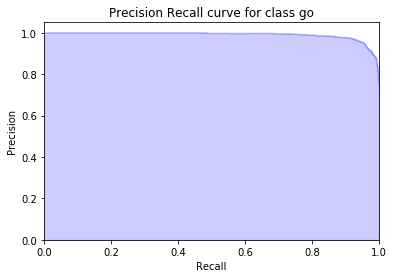

In [17]:
model_go = train_keyword("go", 10, 50)

['go' 'no' 'stop' 'yes']
['stop' 'unkn']
mapping:  {'stop': 0, 'unkn': 1}
Train on 6604 samples, validate on 2900 samples
Epoch 1/10
6604/6604 [==============================] - 6s 984us/step - loss: 0.5634 - acc: 0.7449 - val_loss: 0.5279 - val_acc: 0.7541
Epoch 2/10
6604/6604 [==============================] - 5s 774us/step - loss: 0.3442 - acc: 0.8502 - val_loss: 0.3440 - val_acc: 0.8669
Epoch 3/10
6604/6604 [==============================] - 5s 773us/step - loss: 0.1386 - acc: 0.9488 - val_loss: 0.2038 - val_acc: 0.9214
Epoch 4/10
6604/6604 [==============================] - 5s 773us/step - loss: 0.0781 - acc: 0.9729 - val_loss: 0.1319 - val_acc: 0.9572
Epoch 5/10
6604/6604 [==============================] - 5s 770us/step - loss: 0.0621 - acc: 0.9785 - val_loss: 0.1011 - val_acc: 0.9662
Epoch 6/10
6604/6604 [==============================] - 5s 776us/step - loss: 0.0569 - acc: 0.9812 - val_loss: 0.0812 - val_acc: 0.9703
Epoch 7/10
6604/6604 [==============================] - 5s 772

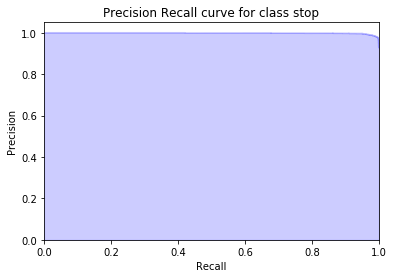

In [18]:
model_stop = train_keyword("stop", 10, 50)

['go' 'no' 'stop' 'yes']
['unkn' 'yes']
mapping:  {'unkn': 0, 'yes': 1}
Train on 6604 samples, validate on 2900 samples
Epoch 1/10
6604/6604 [==============================] - 6s 970us/step - loss: 0.5563 - acc: 0.7498 - val_loss: 0.7308 - val_acc: 0.7431
Epoch 2/10
6604/6604 [==============================] - 5s 791us/step - loss: 0.2783 - acc: 0.8870 - val_loss: 0.4152 - val_acc: 0.8407
Epoch 3/10
6604/6604 [==============================] - 5s 793us/step - loss: 0.1364 - acc: 0.9500 - val_loss: 0.1468 - val_acc: 0.9524
Epoch 4/10
6604/6604 [==============================] - 5s 791us/step - loss: 0.0738 - acc: 0.9727 - val_loss: 0.1046 - val_acc: 0.9648
Epoch 5/10
6604/6604 [==============================] - 5s 799us/step - loss: 0.0652 - acc: 0.9764 - val_loss: 0.1296 - val_acc: 0.9459
Epoch 6/10
6604/6604 [==============================] - 5s 809us/step - loss: 0.0528 - acc: 0.9818 - val_loss: 0.0710 - val_acc: 0.9703
Epoch 7/10
6604/6604 [==============================] - 5s 802us

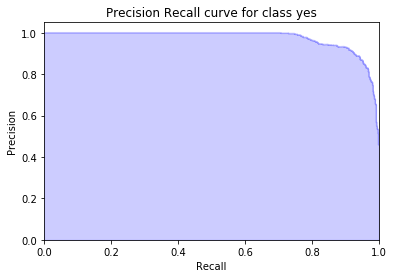

In [19]:
model_stop = train_keyword("yes", 10, 50)

['go' 'no' 'stop' 'yes']
['no' 'unkn']
mapping:  {'no': 0, 'unkn': 1}
Train on 6604 samples, validate on 2900 samples
Epoch 1/10
6604/6604 [==============================] - 6s 982us/step - loss: 0.5746 - acc: 0.7459 - val_loss: 0.5627 - val_acc: 0.7493
Epoch 2/10
6604/6604 [==============================] - 5s 787us/step - loss: 0.5441 - acc: 0.7500 - val_loss: 0.5673 - val_acc: 0.7493
Epoch 3/10
6604/6604 [==============================] - 5s 787us/step - loss: 0.4487 - acc: 0.7553 - val_loss: 0.4514 - val_acc: 0.7572
Epoch 4/10
6604/6604 [==============================] - 5s 788us/step - loss: 0.3729 - acc: 0.8054 - val_loss: 0.3621 - val_acc: 0.8148
Epoch 5/10
6604/6604 [==============================] - 5s 790us/step - loss: 0.2751 - acc: 0.8773 - val_loss: 0.2924 - val_acc: 0.8683
Epoch 6/10
6604/6604 [==============================] - 5s 785us/step - loss: 0.1933 - acc: 0.9213 - val_loss: 0.2329 - val_acc: 0.8972
Epoch 7/10
6604/6604 [==============================] - 5s 789us/s

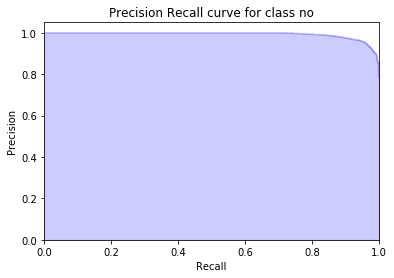

In [20]:
model_stop = train_keyword("no", 10, 50)

In [21]:
!ls rakshak/models

esnb_speech_cmd_go.h5  esnb_speech_cmd_stop.h5
esnb_speech_cmd_no.h5  esnb_speech_cmd_yes.h5
